#### Sentiment Analysis

In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import matplotlib.pyplot as plt

In [2]:
news_df = pd.read_csv("../data/preprocessed/headlines/headlines.csv")
news_df.head()


,Date,Headlines,Newspaper,XLE,XLF,XLK,XLV,XLY
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t...",cnbc,0,0,1,0,0
1,2018-03-20,G20 financial leaders say need more dialogue o...,reuters,0,0,0,0,0
2,2018-03-20,Index provider MSCI says it is reviewing Faceb...,reuters,0,0,0,0,0
3,2018-03-20,UK's Cambridge University questions Facebook a...,reuters,0,0,0,0,0
4,2018-03-20,"Exclusive: On Amazon, a quarter of merchants' ...",reuters,0,0,0,0,1


In [3]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51122 entries, 0 to 51121
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       51122 non-null  object
 1   Headlines  51122 non-null  object
 2   Newspaper  51122 non-null  object
 3   XLE        51122 non-null  int64 
 4   XLF        51122 non-null  int64 
 5   XLK        51122 non-null  int64 
 6   XLV        51122 non-null  int64 
 7   XLY        51122 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 3.1+ MB


In [4]:
news_df["Date"] = pd.to_datetime(news_df["Date"])
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51122 entries, 0 to 51121
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       51122 non-null  datetime64[ns]
 1   Headlines  51122 non-null  object        
 2   Newspaper  51122 non-null  object        
 3   XLE        51122 non-null  int64         
 4   XLF        51122 non-null  int64         
 5   XLK        51122 non-null  int64         
 6   XLV        51122 non-null  int64         
 7   XLY        51122 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 3.1+ MB


#### FinBERT

In [5]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

c:\Users\leszc\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\leszc\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

#### Now we need to convert the "Headlines" column into lists so we can pass it onto our tokenizer

In [6]:
list_headlines = news_df["Headlines"].tolist()
list_headlines

['Cramer: Trump, the Fed and the cloud can get this market back on track',
 'G20 financial leaders say need more dialogue on trade as U.S tariffs loom',
 'Index provider MSCI says it is reviewing Facebook data privacy issue',
 "UK's Cambridge University questions Facebook about academic's role in data breach",
 "Exclusive: On Amazon, a quarter of merchants' sales are cross-border",
 "IMF's Lagarde urges G20 to avoid 'exceptional' trade measures",
 'Tesla denies Musk in talks with Israeli AI vision firm Cortica',
 'General Dynamics raises bid for sector peer CSRA to fend off CACI',
 'Exclusive: Salesforce in advanced talks to buy MuleSoft - sources',
 "Toys 'R' Us says 'making every effort' to pay vendors",
 'Former F-Squared CEO must pay $12.4 million in SEC case: U.S. judge',
 'Fatal U.S. self-driving auto accident raises novel legal questions',
 'Facebook under pressure as U.S., EU urge probes of data practices',
 'Senators to press automakers, regulators on Takata air bag recall',
 

In [7]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

finbert = pipeline(
    task="sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    function_to_apply="softmax",       # ensure probabilities
    top_k=None                         # probabilities for all labels
)



Device set to use cpu


Max length: 38
Mean length: 16.4091584836274
95th percentile: 23


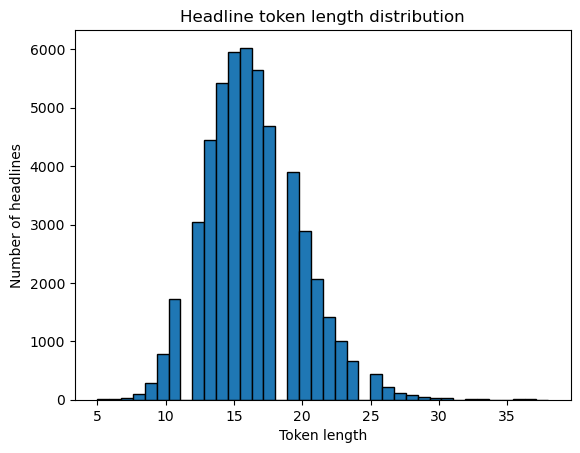

In [8]:
# checking what max_length parameter should be
encodings = tokenizer(
    list_headlines,
    padding=False,
    truncation=False,
    add_special_tokens=True
)

lengths = [len(ids) for ids in encodings["input_ids"]]

print("Max length:", max(lengths))
print("Mean length:", sum(lengths) / len(lengths))
print("95th percentile:", sorted(lengths)[int(0.95 * len(lengths))])

plt.hist(lengths, bins=38, edgecolor='k')
plt.xlabel("Token length")
plt.ylabel("Number of headlines")
plt.title("Headline token length distribution")
plt.show()

In [9]:
finbert_results = finbert(
    list_headlines,
    batch_size=32,
    truncation=True,
    padding=True,
    max_length=64
)


Results is a list (len == len(list_headlines)), each item is a list of dicts:

[{'label': 'positive', 'score': ...}, 

{'label': 'negative', 'score': ...}, 

{'label': 'neutral', 'score': ...}]

In [11]:
id2label = model.config.id2label
labels = [id2label[i].lower() for i in range(len(id2label))]  # e.g. ['positive','negative','neutral']


In [12]:
# map each headline’s list-of-dicts to a dict {label: score}
per_row = []
for row in finbert_results:
    d = {item['label'].lower(): item['score'] for item in row}
    per_row.append(d)

scores_df = pd.DataFrame(per_row)

In [13]:
for col in ["positive", "neutral", "negative"]:
    if col not in scores_df.columns:
        scores_df[col] = np.nan
        
scores_df = scores_df[["positive", "neutral", "negative"]]

In [14]:
scores_df["finbert_label"] = scores_df[["positive", "neutral", "negative"]].idxmax(axis=1)
scores_df["finbert_confidence"] = scores_df[["positive", "neutral", "negative"]].max(axis=1)


In [18]:
df = news_df.reset_index(drop=True).join(scores_df)

df.head(15)

,Date,Headlines,Newspaper,XLE,XLF,XLK,XLV,XLY,positive,neutral,negative,finbert_label,finbert_confidence
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t...",cnbc,0,0,1,0,0,0.381990,0.606314,0.011696,neutral,0.606314
1,2018-03-20,G20 financial leaders say need more dialogue o...,reuters,0,0,0,0,0,0.259833,0.077557,0.662610,negative,0.662610
2,2018-03-20,Index provider MSCI says it is reviewing Faceb...,reuters,0,0,0,0,0,0.018125,0.884106,0.097769,neutral,0.884106
3,2018-03-20,UK's Cambridge University questions Facebook a...,reuters,0,0,0,0,0,0.032822,0.651042,0.316137,neutral,0.651042
4,2018-03-20,"Exclusive: On Amazon, a quarter of merchants' ...",reuters,0,0,0,0,1,0.038724,0.937915,0.023361,neutral,0.937915
5,2018-03-20,IMF's Lagarde urges G20 to avoid 'exceptional'...,reuters,0,0,0,0,0,0.127411,0.345401,0.527188,negative,0.527188
6,2018-03-20,Tesla denies Musk in talks with Israeli AI vis...,reuters,0,0,1,0,1,0.070572,0.667361,0.262067,neutral,0.667361
7,2018-03-20,General Dynamics raises bid for sector peer CS...,reuters,0,0,0,0,0,0.904699,0.042074,0.053227,positive,0.904699
8,2018-03-20,Exclusive: Salesforce in advanced talks to buy...,reuters,0,0,1,0,0,0.105484,0.883377,0.011139,neutral,0.883377
9,2018-03-20,Toys 'R' Us says 'making every effort' to pay ...,reuters,0,0,0,0,0,0.277019,0.692616,0.030365,neutral,0.692616


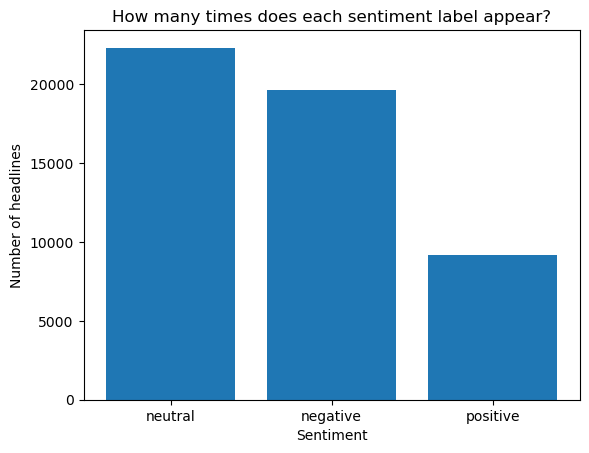

In [19]:
label_counts = df["finbert_label"].value_counts()

plt.bar(label_counts.index, label_counts.values)
plt.title("How many times does each sentiment label appear?")
plt.xlabel("Sentiment")
plt.ylabel("Number of headlines")
plt.show()


Comparing it to the previous setup of FinBERT I tried

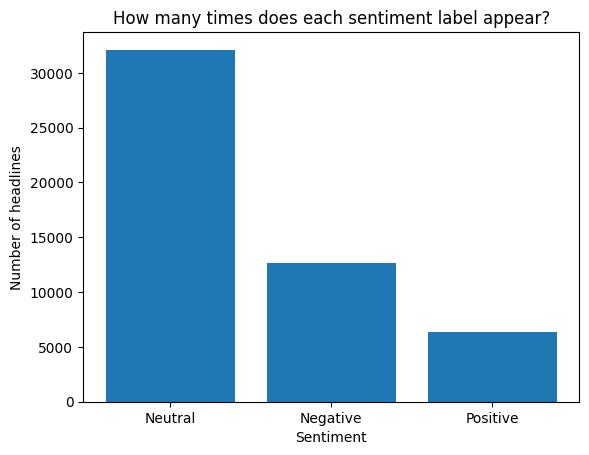

In [ ]:
test_data = pd.read_csv("../data/preprocessed/news_with_sentiment.csv")

label_counts = test_data["finbert_label"].value_counts()

plt.bar(label_counts.index, label_counts.values)
plt.title("How many times does each sentiment label appear?")
plt.xlabel("Sentiment")
plt.ylabel("Number of headlines")
plt.show()

I believe the difference comes from the change in label mapping. In the earlier version I basically hard-coded the labels:

labels = ["positive", "negative", "neutral"], which didn't match FinBERT's actual 1d2label order, so many predictions got mislabeled.

#### Now we'll create GLOBAL(!) daily sentiment indicators

In [22]:
sectors = ["XLE", "XLF", "XLK", "XLV", "XLY"]
sentiment_columns = ["positive", "neutral", "negative"]

daily_global_sentiment_average = (
    df.groupby("Date", as_index=False).agg(
        avg_positive_global = ("positive", "mean"),
        avg_neutral_global = ("neutral", "mean"),
        avg_negative_global = ("negative", "mean"),
        n_headlines = ("Headlines", "count")
    )
)

daily_global_sentiment_average["sent_index_global"] = (daily_global_sentiment_average["avg_positive_global"] - daily_global_sentiment_average["avg_negative_global"])


In [27]:
df = df.merge(daily_global_sentiment_average, on="Date", how="left")
df.head()


,Date,Headlines,Newspaper,XLE,XLF,XLK,XLV,XLY,positive,neutral,...,avg_positive_global_x,avg_neutral_global_x,avg_negative_global_x,n_headlines_x,sent_index_global_x,avg_positive_global_y,avg_neutral_global_y,avg_negative_global_y,n_headlines_y,sent_index_global_y
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t...",cnbc,0,0,1,0,0,0.381990,0.606314,...,0.186842,0.466275,0.346883,81,-0.160042,0.186842,0.466275,0.346883,81,-0.160042
1,2018-03-20,G20 financial leaders say need more dialogue o...,reuters,0,0,0,0,0,0.259833,0.077557,...,0.186842,0.466275,0.346883,81,-0.160042,0.186842,0.466275,0.346883,81,-0.160042
2,2018-03-20,Index provider MSCI says it is reviewing Faceb...,reuters,0,0,0,0,0,0.018125,0.884106,...,0.186842,0.466275,0.346883,81,-0.160042,0.186842,0.466275,0.346883,81,-0.160042
3,2018-03-20,UK's Cambridge University questions Facebook a...,reuters,0,0,0,0,0,0.032822,0.651042,...,0.186842,0.466275,0.346883,81,-0.160042,0.186842,0.466275,0.346883,81,-0.160042
4,2018-03-20,"Exclusive: On Amazon, a quarter of merchants' ...",reuters,0,0,0,0,1,0.038724,0.937915,...,0.186842,0.466275,0.346883,81,-0.160042,0.186842,0.466275,0.346883,81,-0.160042


In [26]:
df.to_csv("../data/preprocessed/headlines/headlines_finbert.csv", index=False)